In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import ensemble
%matplotlib inline

In [2]:
cancer = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data')

In [3]:
cancer.head()

,1000025,5,1,1.1,1.2,2,1.3,3,1.4,1.5,2.1
0,1002945,5,4,4,5,7,10,3,2,1,2
1,1015425,3,1,1,1,2,2,3,1,1,2
2,1016277,6,8,8,1,3,4,3,7,1,2
3,1017023,4,1,1,3,2,1,3,1,1,2
4,1017122,8,10,10,8,7,10,9,7,1,4


In [4]:
cancer.columns = ['Sample_Code',
                  'Thickness',
                  'Size_Uniform',
                  'Shape_Uniform',
                  'Margin_Adhesion',
                  'S_Epi_Cell_Size',
                  'Bare_Nuclei',
                  'Bland_Chromatin',
                  'Normal_Nucleoli',
                  'Mitoses',
                  'Class']

In [5]:
cancer.head()

,Sample_Code,Thickness,Size_Uniform,Shape_Uniform,Margin_Adhesion,S_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1002945,5,4,4,5,7,10,3,2,1,2
1,1015425,3,1,1,1,2,2,3,1,1,2
2,1016277,6,8,8,1,3,4,3,7,1,2
3,1017023,4,1,1,3,2,1,3,1,1,2
4,1017122,8,10,10,8,7,10,9,7,1,4


In [6]:
cancer.dtypes

Sample_Code         int64
Thickness           int64
Size_Uniform        int64
Shape_Uniform       int64
Margin_Adhesion     int64
S_Epi_Cell_Size     int64
Bare_Nuclei        object
Bland_Chromatin     int64
Normal_Nucleoli     int64
Mitoses             int64
Class               int64
dtype: object

In [7]:
cancer['Bare_Nuclei'] = pd.to_numeric(cancer['Bare_Nuclei'], errors='coerce')

In [8]:
cancer = cancer.dropna(axis=0, how='any')

In [9]:
cancer.head(1)

,Sample_Code,Thickness,Size_Uniform,Shape_Uniform,Margin_Adhesion,S_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1002945,5,4,4,5,7,10.0,3,2,1,2


In [10]:
X = cancer.drop(['Class','Sample_Code'],axis=1)

In [11]:
Y = pd.get_dummies(data=cancer, columns=['Class'])

In [12]:
Y = Y['Class_4']

The example did not have us split the data before training the network so I did not do that here either. I also used the whole dataset with the Random Forest, wanting to keep the procedures with both models exactly the same. 

In [13]:
# Neural Network
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(200, 150, 200), alpha=.01,)
mlp.fit(X, Y)
mlp.score(X, Y)

0.9882697947214076

In [14]:
# Random Forest
forest = ensemble.RandomForestClassifier()

forest_type_param = {'n_estimators': (100, 200, 300),
                       'criterion': ('gini', 'entropy'),
                       'max_depth': (2, 3, 5)}

NN_type_param = {'activation':('identity', 'logistic', 'tanh', 'relu'),
                 'solver': ('lbfgs', 'sgd', 'adam'),
                 'alpha': (.0001, .01, .1, .3, .5)} 

In [15]:
from sklearn.model_selection import GridSearchCV

def check_grid(estimator, params, X, y):
    grid_classifier = GridSearchCV(estimator=estimator, param_grid=params)
    grid_classifier.fit(X, y)
    grid_score = grid_classifier.score(X, y)
    return (grid_classifier, grid_score)


In [16]:
check_grid(forest, forest_type_param, X, Y)

(GridSearchCV(cv=None, error_score='raise',
        estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
        fit_params=None, iid=True, n_jobs=1,
        param_grid={'n_estimators': (100, 200, 300), 'criterion': ('gini', 'entropy'), 'max_depth': (2, 3, 5)},
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring=None, verbose=0), 0.9838709677419355)

The scores are 1.0 for the neural network and .96 for the Random Forest. Both the mlp.score and GridSearchCV return accuracy score.

I have no idea how long this ran. I waited for 17 minutes and then walked away to pick up my kids and then I came back 2 hours later and it had finished. 

In [17]:
forest.fit(X,Y).feature_importances_

array([0.04384772, 0.18564831, 0.2651323 , 0.01574909, 0.08483589,
       0.13276271, 0.15203039, 0.11266817, 0.00732543])

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


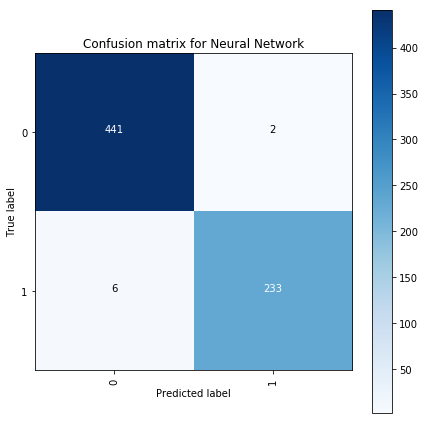

In [19]:
from sklearn import metrics
import itertools

mlp_y_pred = mlp.predict(X)
c_matrix = metrics.confusion_matrix(Y, mlp_y_pred)

class_names = Y.unique()

plt.figure(figsize=(6, 6))
plot_confusion_matrix(c_matrix, classes=class_names,
                      title='Confusion matrix for Neural Network',
                      cmap=plt.cm.Blues)
plt.show()


Confusion matrix, without normalization


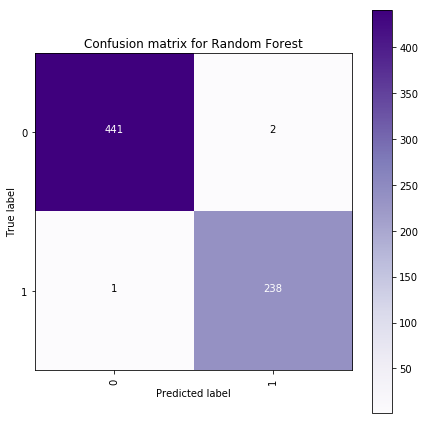

In [20]:

RF_y_pred = forest.fit(X,Y).predict(X)
c_matrix = metrics.confusion_matrix(Y, RF_y_pred)

class_names = Y.unique()

plt.figure(figsize=(6, 6))
plot_confusion_matrix(c_matrix, classes=class_names,
                      title='Confusion matrix for Random Forest',
                      cmap=plt.cm.Purples)
plt.show()


# Thoughts

Both the random forest and the mlp classifiers did an excellent job of correctly classifying malginant tumors against benign. The time cost for the mlp was considerable and depending on how you scale up the data, could be a reason to choose a different estimator. But if time is less important than correctly identifying positives, it could be worth the wait.